# Konveierid (*Pipeline*), mudelite hindamine ja hüperparameetrite tuunimine


## Sisukord

* [Konveier](#konveier)
* [Ülesanne 7.1](#7_1)
* [Andmete ristkontroll](#ristkontroll)
* [Õppimiskõverad](#õppimiskõverad)
* [Validatsioonikõverad](#validatsioonikõverad)
* [Hüperparameetrite tuunimine](#hüper)
* [Eksimismaatriks](#Eksimismaatriks)
* [ROC kõver](#roc)
* [Ülesanne 7.2](#7_2)

Põhineb S.Raschka *Python Machine Learnig* raamatu [peatükil 6](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb) ([*MIT litsents*](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)).

<a id='konveier'></a>
## Konveier (pipeline)

Nagu oleme näinud, on andmeanalüüsis tavaliselt mitu sammu: standardiseerimine/normaliseerimine, dimensionaalsuse vähendamine, ennustava mudeli treenimine ja kasutamine. Konveier ([Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)) kombineerib erinevad transfomaatorid ja ennustajad kokku ühendobjektiks, mille liideses on muu hulgas  fit() ja transform() meetodid.

In [187]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pandas as pd

bc_data = load_breast_cancer()
X = bc_data.data
y = bc_data.target


Tekitame konveieri, mille sammudeks on standardiseerimine, PCA ja logistiline regressioon. Konveieri tekitamisel anname me sinna kaasa listi `(nimi, komponent)` paaridest. Nimi on vabalt valitav string.

In [188]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(random_state=1))])



Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, 
siis selle `fit_transform()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n-1}` teisendusmeetodeid `fit_transform()`
(kõigepealt `fit()`, seejärel `transform()`).


Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, siis selle `fit()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n-1}` teisendusmeetodeid `fit_transform()` (kõigepealt `fit()`, seejärel `transform()`) ja lõpuks viimase komponendi `p_n.fit(X, y)` meetodit, salvestades tulemuse.

`pipeline.fit(X, y): 
                     p_n.fit(p_{n-1}.fit_transform(
                              ...
                             p_2.fit_transform(
                             p_1.fit_transform(X))),...), y)`

In [189]:
pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

Täpsus:  0.9473684210526315


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Kui meie konveier `pipeline` koosneb n komponendist `p_1..., p_n`, siis selle `predict()` meetod rakendab andmestikule `X` järjest komponentide `p1,... p_{n-1}` teisendusmeetodeid `transform()`ja lõpuks viimase komponendi `p_n.predict(X)` meetodit, salvestades tulemuse.

`pipeline.predict(X): 
                 p_n.predict(p_{n-1}.transform(
                              ...
                             p_2.transform(
                             p_1.transform(X))))`

In [190]:
y_pred = pipe_lr.predict(X_test)
sum(y_pred == y_test) / len(y_test)

0.9473684210526315

<a id='ristkontroll'></a>
## Ristkontroll (cross-validation)

$k$-kordne ristkontroll jagab andmestiku $k$ võrdseks juhuvalimiks, kus $k-1$ juhuvalimit kasutatakse treeninguks ja viimast juhuvalimit testimiseks. Seda protseduri korratakse k korda, kuni testitud on kõiki juhuvalimeid. Koguhinnang $E$ (täpsus vms) on keskmine hinnang üle $k$ hinnangu:

$$E = \sum_{i=1}^k E_i $$

Scikit-learn teegis on ristkontrolliks moodulis model_selection klassid, nagu [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold), mis võimaldavad täpsemat kontrolli iteratsiooniks üle $k$ valimi ja lihtsamat funktsiooni [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html), mis tagastab täpsusskoorid iga $k$ valimi jaoks ja võimaldab paralleeltööd mitme protsessoriga (parameeter `n_jobs`).

In [191]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold




Parameeter `cv` on korduste/juhuvalimite arv.
Parameeter `n_jobs` on lõimede/kasutatavate protsessorite arv.

In [192]:
#%%timeit # Jupyteri käsk ajakulu mõõtmiseks

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

In [193]:
print('CV täpsused: ', scores)
print('CV keskmine täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))

CV täpsused:  [0.89130435 0.97826087 0.97826087 0.91304348 0.93478261 0.97777778
 0.93333333 0.95555556 0.97777778 0.95555556]
CV keskmine täpsus: 0.950 +/- 0.029


Meetod `StratifiedKFold.split(X, y)` tagastab listi paaridest `(treeningandmete_indeksid, testandmete_indeksid)`.

In [194]:
kfold = StratifiedKFold(n_splits=10)
for train, test in kfold.split(X_train, y_train):
    #print("train: ", train)
    #print("test: ", test)
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    print("score:", score)
    

score: 0.8913043478260869
score: 0.9782608695652174
score: 0.9782608695652174
score: 0.9130434782608695
score: 0.9347826086956522
score: 0.9777777777777777
score: 0.9333333333333333
score: 0.9555555555555556
score: 0.9777777777777777
score: 0.9555555555555556


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

<a id='7_1'></a>
## Ülesanne 7.1

* Kontrollida eelneva konveieri ([StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)) tulemust, sooritades vastavad `fit_transform()` ja `predict()` sammud ilma konveierit kasutamata.


* Tekitada eelneva andmestiku (load_breast_cancer()) peal  komponentidest [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) koosnev konveier ja hinnata selle täpsust.


* Tekitada eelneva andmestiku (load_breast_cancer()) peal komponentidest [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html),
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html) koosnev konveier ja hinnata selle täpsust.

 
* Hinnata [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html),
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) konveieri täpsust 10x ristkontrolliga.


* Hinnata [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html),
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)  konveieri täpsust 10x ristkontrolliga.

In [289]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold

bc_data = load_breast_cancer()
X = bc_data.data
y = bc_data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', LogisticRegression())])

pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

sc = StandardScaler()
pca = PCA()
regression = LogisticRegression()

regression.fit(pca.fit_transform(sc.fit_transform(X_train)), y_train)
print("Täpsus:", regression.score(X_test, y_test))

Täpsus:  0.9824561403508771
Täpsus: 0.3684210526315789


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [196]:
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('sc1', SelectKBest()),
                    ('pca', DecisionTreeClassifier())])

pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV keskmine täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))

Täpsus:  0.9298245614035088
CV keskmine täpsus: 0.952 +/- 0.027


In [212]:
from sklearn.linear_model import Perceptron

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('sc1', StandardScaler()),
                    ('pca', PCA()),
                    ('clf', Perceptron())])

pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

scores = cross_val_score(estimator=pipe_lr,
                         X=X_train,
                         y=y_train,
                         cv=10,
                         n_jobs=1)
print('CV keskmine täpsus: %.3f' % np.mean(scores), "+/- %.3f" % np.std(scores))

Täpsus:  0.9736842105263158
CV keskmine täpsus: 0.965 +/- 0.024


<a id='õppimiskõverad'></a>
## Õppimiskõverad


Õppimiskõver näitab treening- ja testtäpsuse sõltuvust andmestiku suurusest. See võimaldab hinnata kuivõrd paraneks täpsus andmemahtu suurendades.

In [198]:
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('clf', LogisticRegression(penalty='l2', max_iter=300, random_state=0))])



In [199]:


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=1)


print("train sizes:", train_sizes)
print("train scores:\n", np.round(train_scores, 3))
print("test scores:\n", np.round(train_scores, 3))


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

train sizes: [ 20  63 106 149 193 236 279 322 365 409]
train scores:
 [[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984]
 [0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991]
 [0.993 0.987 0.987 0.993 0.993 0.993 0.993 0.993 0.993 0.993]
 [0.995 0.99  0.99  0.995 0.99  0.99  0.99  0.99  0.99  0.99 ]
 [0.996 0.987 0.992 0.996 0.992 0.992 0.992 0.992 0.992 0.992]
 [0.993 0.989 0.993 0.993 0.993 0.993 0.993 0.993 0.993 0.993]
 [0.991 0.988 0.991 0.991 0.991 0.991 0.994 0.994 0.994 0.994]
 [0.992 0.989 0.992 0.992 0.992 0.992 0.992 0.992 0.992 0.992]
 [0.99  0.988 0.99  0.99  0.993 0.993 0.993 0.993 0.993 0.993]]
test scores:
 [[1.    1.    1.    1.    1.    1.    1.    1.    1.    1.   ]
 [1.    0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984 0.984]
 [0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991 0.991]
 [0.993 0.987 0.987 0.993 0.993 0.993 0.993 0.993 0.993 0.993]
 [0.995 0.99  0.99  0.995 0.99  0

C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [200]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

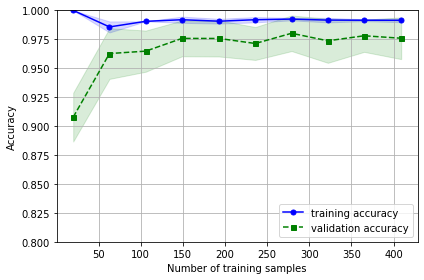

In [201]:
# Kood: https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch06/ch06.ipynb
# S.Raschka, Python Machine Learning

import matplotlib.pyplot as plt


%matplotlib inline



plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/learning_curve.png', dpi=300)
plt.show()

<a id='validatsioonikõverad'></a>
##  Validatsioonikõverad (*validation curves*)


Validatsioonikõver näitab treening- ja testtäpsuse sõltuvust klassifikaatori teatud treeningparameetrist. See võimaldab hinnata selle parameetri mõju ja optimaalset väärtust.

C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

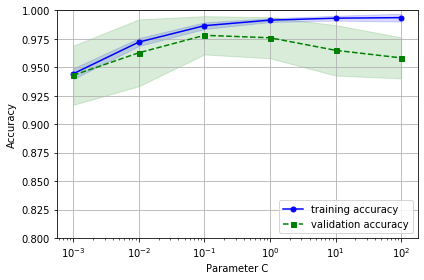

In [202]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

<a id='hüper'></a>
## Hüperparameetrite tuunimine

Ennustavatel mudelitel on tüüpiliselt hulk parameetreid, mille abil juhitakse treeningprotsessi, mida võib nimetada hüperparameetriteks. Need erinevad parameetritest, mida treenitakse (närvivõrgu kaalud jms) ja nende seadistusest võib sõltuda mudeli headus. Hüperparameetrite tuunimine tähendab mingi mõõdiku järgi (täpsus vms) optimaalsete parameetrite automaatset otsingut.

Scikit-learn pakub selleks klasse, nagu [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html).

In [203]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'clf__C': param_range, 
               'clf__penalty': ['l1', 'l2']}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.978021978021978
{'clf__C': 0.1, 'clf__penalty': 'l2'}


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [204]:
pipe_lr_tuned = Pipeline([('sc1', StandardScaler()),
                    ('clf', LogisticRegression(C=0.1, penalty='l2', random_state=1))])


<a id='Eksimismaatriks'></a>
## Eksimismaatriks (*confusion matrix*)

Eksimismaatriks on 2x2 maatriks: ennustatud klass võib olla positiivne või negatiivne, tegelik klass võib olla positiivne või negatiivne. Ideaalis langevad ennustatud ja tegelikud väärtused alati kokku, aga kui mitte, siis võib olla oluline, mis tüüpi vigadega on valdavalt tegemist: kas **valepositiivsete** või **valenegatiivsete** tulemustega. Erineval veal võivad olla erinevad kaalud (haiguse tuvastamata jätmine on tavaliselt tõsisem probleem kui ekslik positiivne diagnoos), klasside jaotus ei pruugi olla 50:50, mis muudab täpsuse vahel eksitavaks mõõduks (mudel, mis ennustab alati sagedaseimat tulemust näitab head täpsust) jne. 

`
 |           | Ennustatud P         | Ennustatud N         |
 |-----------|----------------------|----------------------|
 | Tegelik P | Õige positiivne (TP) | Vale negatiivne (FN) |
 |-----------|----------------------|----------------------|
 | Tegelik N | Vale positiivne (FP) | Õige negatiivne (TN) |
 |-----------|----------------------|----------------------|`
 
 Scikit-learn moodul metrics pakub eksimismeetriksi genereerimiseks funktsiooni [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix).

In [205]:
from sklearn.metrics import confusion_matrix

pipe_lr_tuned.fit(X_train, y_train)
y_pred = pipe_lr_tuned.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[39  3]
 [ 0 72]]


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Väärtuste $TP, TN, FP, FN$ on võimalik defineerida järgmised mõõdikud: 


Ennustusviga (ERR) ja täpsus (ACC):

$$ ERR = \frac{FP + FN}{FP + FN + TP + TN} $$


$$ ACC = \frac{TP + TN}{FP + FN + TP + TN} = 1 - ERR $$

Tundlikkus ehk õige-positiivsete määr (TPR), tuntud ka  kui täielikkus (Recall REC):
$$ TPR = REC = \frac{TP}{FN + TP}$$

Spetsiifilisus ehk õige-negatiivsete määr (TNR):
$$ TNR = \frac{TN}{FP + TN}$$

Positiivne ennustusvõime (Precision, PRE):

$$ PRE = \frac {TP} {TP+FP} $$


Tihti kombineeritakse $PRE$ ja $REC$ nn $F1$ skooriks:

$$ F1 = 2 \frac{PRE \times REC} {PRE + REC} $$

Vastavad funktsioonid nende mõõdikute leidmiseks on saadaval moodulis [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics).


<a id='roc'></a>
## ROC kõver


Kui meetod väljastab klassi asemel tõenäosushinnangu vahemikus 0..1, siis kerkib küsimus, milline lävi oleks sobilik klassikuuluvuse osas positiivse otsuse tegemiseks? 0.5 on intuitiivne lävi, aga ei pruugi olla parim, eriti kui valepositiivse ja valenegatiivse tulemuse "hind" pole võrdne. Suurendades läve vähendame valepositiivsete tulemuste arvu, aga samas ka õigete positiivsete tulemuste  arvu. ROC kõver visualiseerib seda olukorda, näidates x-teljel vale-positiivsete tulemuste ja y-teljel õigete positiivsete tulemuste protsenti. Läve enda väärtust telgedel otse näha ei ole, lävi on kõvera vastavas punktis see, mis annab tulemuseks punkti poolt määratud õige/vale - positiivsete tulemuste arvu.

Optimaalsed läved minimeerivad kaugust koordinaatide vasakust ülanurgast (õiged positiivsed: 100%, valepositiivsed 0%).

Klassifikaatori summaarse headuse mõõduna kasuatakse tihti ka kõvera aluse pindala (*area-under-curve*) mõõtu.


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


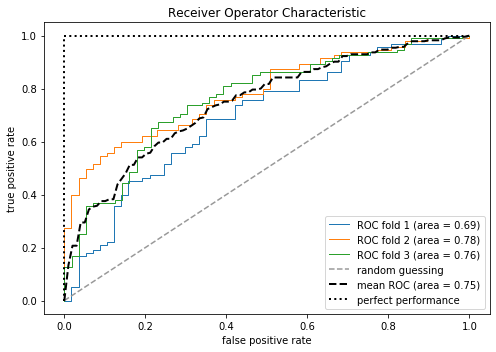

In [206]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

pipe_lr = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=2)),
                    ('clf', LogisticRegression(penalty='l2', 
                                               random_state=0, 
                                               C=100.0))])

X_train2 = X_train[:, [4, 14]]

    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             lw=1,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         lw=2,
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")

plt.tight_layout()
# plt.savefig('./figures/roc.png', dpi=300)
plt.show()

<a id='7_2'></a>
## Ülesanne 7.2



* Joonistada õppimis- ja validatsioonikõverad kasutades standardiseerimise asemel normaliseerimist ([MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)). 

* Tuunida järgmiste konveierite järgmised hüperparameetrid:
    * [SelectKBest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html): k,
[DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html): criterion, max_depth.
    * [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html), 
[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html): n_components,
[Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html): eta0, max_iter, penalty. Siin tasub olla ettevaatlik valikutest tulenevate kombinatsioonide arvuga, muidu võib tööaeg kujuneda pikaks.

* Seadistada need kaks konveierit leitud optimaalsete hüperparameetritega ja leida neile eksimismaatriksid.

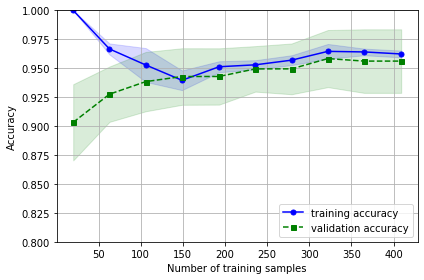

In [207]:
from sklearn.model_selection import learning_curve

pipe_lr = Pipeline([('scl', MinMaxScaler()),
                    ('clf', LogisticRegression(penalty='l2', max_iter=300, random_state=0, solver='lbfgs'))])


train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.05, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


%matplotlib inline


plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.tight_layout()
plt.show()

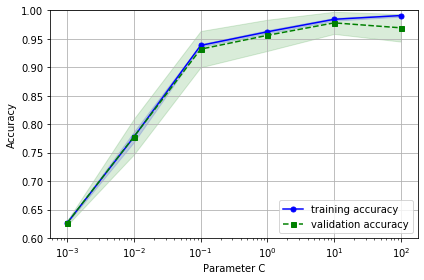

In [208]:
from sklearn.model_selection import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
                estimator=pipe_lr, 
                X=X_train, 
                y=y_train, 
                param_name='clf__C', 
                param_range=param_range,
                cv=10)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, 
         color='blue', marker='o', 
         markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean + train_std,
                 train_mean - train_std, alpha=0.15,
                 color='blue')

plt.plot(param_range, test_mean, 
         color='green', linestyle='--', 
         marker='s', markersize=5, 
         label='validation accuracy')

plt.fill_between(param_range, 
                 test_mean + test_std,
                 test_mean - test_std, 
                 alpha=0.15, color='green')

plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1.0])
plt.tight_layout()
# plt.savefig('./figures/validation_curve.png', dpi=300)
plt.show()

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('skb', SelectKBest()),
                    ('dtc', DecisionTreeClassifier())])

pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

param_grid = [{'skb__k': [1, 2, 3, 4, 5, 6, 7], 
               'dtc__criterion': ["gini", "entropy"],
               'dtc__max_depth': [10, 20, 30]}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print('Täpsus: ', gs.best_score_)
print(gs.best_params_)

Täpsus:  0.9122807017543859
Täpsus:  0.9428571428571428
{'dtc__criterion': 'gini', 'dtc__max_depth': 10, 'skb__k': 7}


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

pipe_lr = Pipeline([('sc', StandardScaler()),
                    ('pca', PCA()),
                    ('per', Perceptron())])

pipe_lr.fit(X_train, y_train)
print('Täpsus: ', pipe_lr.score(X_test, y_test))

param_grid = [{'pca__n_components': [1, 5, 10, 20], 
               'per__eta0': [1, 2, 3, 4, 5, 6, 7],
               'per__max_iter': [10, 100, 100],
               'per__penalty': ["elasticnet", "l1", "l2"]}]

gs = GridSearchCV(estimator=pipe_lr, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print('Täpsus: ', gs.best_score_)
print(gs.best_params_)

Täpsus:  0.9736842105263158
Täpsus:  0.9758241758241758
{'pca__n_components': 10, 'per__eta0': 4, 'per__max_iter': 100, 'per__penalty': 'elasticnet'}


C:\Users\envomp\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
